# Protein Realetionship Prediciton #



DeepChem library official website : https://deepchem.io/

In [339]:
import deepchem as dc
import numpy as pd
import pandas as pd
import seaborn as sns
import pickle # Inorder to save data frame dictionary
import os

In [321]:
def PRINT(text) -> None: print(f"{'~'*80}\n{text}\n{'~'*80}")

def print_dict_meaningful(dictionary):
    for key, value in dictionary.items():
        print(f'{key}: {value}')

## Preparing Datasets for Predictive Modeling ##

### Load Required Datasets ###

In [3]:
pwd

'C:\\Users\\gavvi\\Desktop\\Programming\\GitHub\\DeepLearningResearchStarship\\Project 4 Protein Relationship Prediction'

In [4]:
pred_dataset_path = "data/dataset_for_prediction.csv"
ChEMBL_integrin_dataset_path = "data/ChEMBL_Integrins.csv"

In [5]:
pred_df = pd.read_csv(pred_dataset_path)

pred_df.head(5)

,smiles,uniprot_id1
0,OC(=O)[C@H](Cc1ccc(NC(=O)c2c(Cl)cccc2Cl)cc1)NC...,P13612
1,C\C=C\[C@@H](CC(=O)O)NC(=O)C[C@@H](CC(C)C)NC(=...,P05556
2,CN1[C@@H](CCCN=C(N)N)C(=O)NCC(=O)N[C@@H](CC(=O...,P05106
3,OC(=O)C(CNC(=O)CCCCc1ccc2CCCNc2n1)c3cnc4ccccc4c3,P05106
4,OC(=O)C[C@H](NC(=O)CN1CCC[C@@H](CCC2CCNCC2)C1=...,P05106


Next, we aim to rename the column *uniprot_id1* to *uniprot_id*. The rationale behind this decision is that we intend to search for this value in the *ChEMBL* data frame within both the *uniprot1* and *uniprot2* columns. To minimize confusion, we will rename this column

In [6]:
pred_df = pred_df.rename(columns={'uniprot_id1':'uniprot_id'})

PRINT(f'Renamed column name: {pred_df.columns[1]}')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Renamed column name: uniprot_id
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [15]:
chmbl_df = pd.read_csv(ChEMBL_integrin_dataset_path)

chmbl_df.head(5)

,Canonical SMILES(RDKit),Target Pref Name,Organism,UniProt1,UniProt2,UniProt3,UniProt4,UniProt5
0,N=C(N)NCCC[C@H](NC(=O)[C@H](CCCNC(=N)N)NC(=O)[...,Integrin alpha-4/beta-7,Mus musculus,Q00651,P26011,NaN,NaN,NaN
1,N=C(N)NCCC[C@H](NC(=O)CCCC[C@@H]1SC[C@@H]2NC(=...,Integrin alpha-4/beta-7,Mus musculus,Q00651,P26011,NaN,NaN,NaN
2,N#Cc1ccc(-c2ccc(C[C@H](NC(=O)[C@H](CCCNC(=N)N)...,Integrin alpha-4/beta-7,Mus musculus,Q00651,P26011,NaN,NaN,NaN
3,N=C(N)NCCC[C@H](NC(=O)CCCC[C@@H]1SC[C@@H]2NC(=...,Integrin alpha-4/beta-7,Mus musculus,Q00651,P26011,NaN,NaN,NaN
4,N=C(N)NCCC[C@H](NC(=O)CCCC[C@@H]1SC[C@@H]2NC(=...,Integrin alpha-4/beta-7,Mus musculus,Q00651,P26011,NaN,NaN,NaN


### Generate Unique Datasets ###

#### Prechecks ####

In [22]:
unique_proteins = pred_df["uniprot_id1"].unique()

In [26]:
PRINT(f"The unique proteins we want to predict their partners in the PPI are :\n {unique_proteins}\n\nThe are total {len(unique_proteins)} such proteins")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The unique proteins we want to predict their partners in the PPI are :
 ['P13612' 'P05556' 'P05106' 'P05107' 'P08648' 'P17301']

The are total 6 such proteins
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


#### Datasets Generation Phase ####

The next step is to generate six datasets, each for the protein for which we intend to create a deep learning model to predict its companion in PPI (i.e., the second UniProt_id).

The way we are going to achieve this is by taking each unique *UniProt_id* value, searching for all the rows in the *ChEMBL* data frame we loaded from the previous project, where that *UniProt_id* value is one of their *UniProt_id{i}* columns, where i ∈ [1,5].

Each dataset will contain all the molecules' *SMILES* values, with both *UniProt_ids* forming the connection.

From these datasets, we will proceed to train our model. Thus, we can provide the unique SMILES value along with the UniProt_id to the model, and it will predict its partner.

In [69]:
protein_dataframes = {}

for protein in unique_proteins:
    # Initialize an empty list to store rows for the current protein
    rows_for_protein = []

    # Iterate over each row in the ChEMBL DataFrame
    for index, row in chmbl_df.iterrows():
        # Check if the current protein is present in any of the UniProt columns
        if protein in row[['UniProt1', 'UniProt2', 'UniProt3', 'UniProt4', 'UniProt5']].values:
            # Determine the correct order (UniProt1 and UniProt2) in the new data frame
            if row['UniProt1'] == protein:
                relevant_info = [row['Canonical SMILES(RDKit)'], row['UniProt1'], row['UniProt2']]
            elif row['UniProt2'] == protein:
                relevant_info = [row['Canonical SMILES(RDKit)'], row['UniProt2'], row['UniProt1']]
            else:
                relevant_info = []

            if relevant_info:
                rows_for_protein.append(relevant_info)
                
    if rows_for_protein:
        protein_dataframes[protein] = pd.DataFrame(rows_for_protein, columns=['SMILES', 'UniProt1', 'UniProt2'])


In [49]:
protein_dataframes['P13612']

,SMILES,UniProt1,UniProt2
0,COc1ccccc1-c1ccc(C[C@H](NC(=O)c2ccccc2Cl)C(=O)...,P13612,P26010
1,Cc1ccccc1NC(=O)Nc1ccc(CC(=O)N2C[C@@H](F)C[C@H]...,P13612,P26010
2,CN(C)Cc1ccccc1-c1ccc(C[C@H](NC(=O)c2ccccc2Cl)C...,P13612,P26010
3,Cc1cccc(Cl)c1C(=O)N[C@@H](Cc1ccc(NC(=O)c2c(Cl)...,P13612,P26010
4,COc1cnn(C)c(=O)c1-c1ccc(C[C@H](NC(=O)c2c(C)noc...,P13612,P26010
...,...,...,...
1969,CC(C)(C)[C@H]1CC[C@H](C[C@H](NC(=O)[C@@H]2CCC(...,P13612,P05556
1970,O=C(Nc1ccc(C[C@H](/N=c2\c(O)c(O)\c2=N/Cc2ccccc...,P13612,P05556
1971,N#Cc1cccc(S(=O)(=O)N2C[C@H](N3CCC(F)CC3)C[C@H]...,P13612,P05556
1972,CCCCS(=O)(=O)N[C@@H](Cc1ccc(OCCCCC2CCNCC2)cc1)...,P13612,P05556


#### Save the Data Frames Dictionary ####

In [323]:
directory_path = 'obj'

# Save the dictionary to a file in the specified directory
with open(os.path.join(directory_path, 'data_frames_dictionary.pkl'), 'wb') as file:
    pickle.dump(protein_dataframes, file)

#### Save the Generated Data Frame as CSV Files ####

In [50]:
out_dir = 'unique UniProt csv files'

In [51]:
for protein, df in protein_dataframes.items():
    try:
        # Generate csv file name with the desired format
        file_name = f'{protein}.csv'

        # Specify full path
        out_path = os.path.join(out_dir, file_name)

        # Save current data frame as csv file
        df.to_csv(out_path, index=False)

        PRINT(f'Saved data frame for {protein} as {file_name}')
        
    except Exception as e:
        PRINT(f'Error!\nVerify path name and the data')
    

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Saved data frame for P13612 as P13612.csv
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Saved data frame for P05556 as P05556.csv
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Saved data frame for P05106 as P05106.csv
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Saved data frame for P05107 as P05107.csv
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Saved data frame for P08648 as P08648.csv
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

### Visualize Distributions for each Data Frame ###

In [60]:
PRINT(f'We have {len(protein_dataframes.items())} data frames to visualize information about their data distributions')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
We have 6 data frames to visualize information about their data distributions
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [62]:
PRINT(f'UniProt_ids -> {unique_proteins}')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
UniProt_ids -> ['P13612' 'P05556' 'P05106' 'P05107' 'P08648' 'P17301']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


#### Helper Functions ####

##### Helper One-Hot-Encoding Function #####

In [215]:
def one_hot_encoding(df):
    
    df_encoded = pd.get_dummies(df[['UniProt1', 'UniProt2']], prefix='', prefix_sep='').astype(int)
    df_encoded = pd.concat([df[['SMILES']], df_encoded], axis=1)
    return df_encoded

##### Helper Visualization Function #####

In [203]:
def visualize_dist(df, target_prot)-> None:
    # Melt the DataFrame to long format for Seaborn countplot
    df_melted = df.melt(var_name='Protein', value_name='Interaction Status')

    # Set the size of the plot
    sns.set(rc={'figure.figsize':(12, 8)})
    
    sns.set_context("notebook", rc={"lines.linewidth": 2.5})
    # Create a grouped count plot
    sns.countplot(x='Protein', hue='Interaction Status', palette=["lightgrey", "skyblue"], data=df_melted)

    # Add labels and title
    plt.xlabel('Protein')
    plt.ylabel('Count')
    plt.title(f'PPI with -> {target_prot}')

    sns.despine()
    sns.set_theme(style="whitegrid")
    sns.despine(offset=10, trim=True)
    sns.set_context("notebook")
    plt.show()

##### Helper Column Filter Function ######

In [180]:
def filter_proteins_list(df, columns_to_remove):
    
    filtered_columns = [col for col in df.columns if col not in columns_to_remove]
    filtered_columns_list = list(filtered_columns)
    return filtered_columns

#### First Data Frame ####

In [228]:
first_df = protein_dataframes[unique_proteins[0]]

first_df.head(2)

,SMILES,UniProt1,UniProt2
0,COc1ccccc1-c1ccc(C[C@H](NC(=O)c2ccccc2Cl)C(=O)...,P13612,P26010
1,Cc1ccccc1NC(=O)Nc1ccc(CC(=O)N2C[C@@H](F)C[C@H]...,P13612,P26010


##### Visualize Distribution #####

In [234]:
first_df_encoded = one_hot_encoding(first_df)

In [235]:
print(first_df_encoded.columns)

Index(['SMILES', 'P13612', 'P05556', 'P26010'], dtype='object')


In [236]:
first_df_encoded.head(3)

,SMILES,P13612,P05556,P26010
0,COc1ccccc1-c1ccc(C[C@H](NC(=O)c2ccccc2Cl)C(=O)...,1,0,1
1,Cc1ccccc1NC(=O)Nc1ccc(CC(=O)N2C[C@@H](F)C[C@H]...,1,0,1
2,CN(C)Cc1ccccc1-c1ccc(C[C@H](NC(=O)c2ccccc2Cl)C...,1,0,1


In [237]:
filtered_columns = filter_proteins_list(first_df_encoded, columns_to_remove = ['SMILES', 'P13612'])
PRINT(f'Filtered columns -> {filtered_columns}')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Filtered columns -> ['P05556', 'P26010']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [238]:
temp_df_1 = first_df_encoded[filtered_columns]

temp_df_1.head(2)

,P05556,P26010
0,0,1
1,0,1


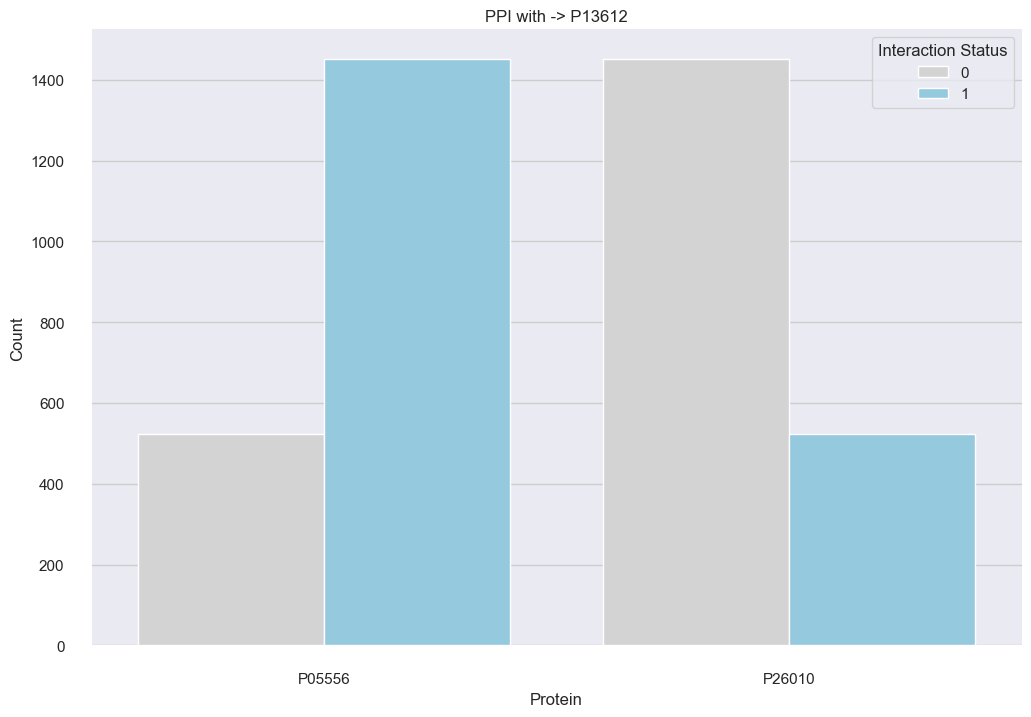

In [268]:
visualize_dist(temp_df_1, unique_proteins[0])

As we can see from the histogram, `P05556` appears much more than `P26010` in the PPI with UniProt traget `P13612`

###### Explore the First Data Frame ######

In [251]:
PRINT(f'The size of the data frame is -> {len(first_df)}')
print(f'Number of times P05556 appears -> {len(first_df[first_df["UniProt2"] == "P05556"])}')
print(f'Number of times P26010 appears -> {len(first_df[first_df["UniProt2"] == "P26010"])}')
print(f'Size check -> {({len(first_df)} == {(len(first_df[first_df["UniProt2"] == "P05556"]) + len(first_df[first_df["UniProt2"] == "P26010"]))})}')

PRINT('Done.')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The size of the data frame is -> 1974
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Number of times P05556 appears -> 1452
Number of times P26010 appears -> 522
Size check -> True
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Done.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


#### Second Data Frame ####

In [222]:
second_df = protein_dataframes[unique_proteins[1]]

second_df.head(2)

,SMILES,UniProt1,UniProt2
0,CC(C)(C)c1cc(Br)cc([C@H](CC(=O)O)NC(=O)CNC(=O)...,P05556,O75578
1,O=C(NCc1ccccc1)NC[C@H](NC(=O)[C@@H]1CCCN1S(=O)...,P05556,P56199


##### Visualize Distribution #####

In [223]:
second_df_encoded = one_hot_encoding(second_df)

In [252]:
second_df_encoded.columns

Index(['SMILES', 'P05556', 'O75578', 'P05106', 'P06756', 'P08648', 'P13612',
       'P17301', 'P23229', 'P56199', 'Q13797'],
      dtype='object')

In [224]:
second_df_encoded.head(3)

,SMILES,P05556,O75578,P05106,P06756,P08648,P13612,P17301,P23229,P56199,Q13797
0,CC(C)(C)c1cc(Br)cc([C@H](CC(=O)O)NC(=O)CNC(=O)...,1,1,0,0,0,0,0,0,0,0
1,O=C(NCc1ccccc1)NC[C@H](NC(=O)[C@@H]1CCCN1S(=O)...,1,0,0,0,0,0,0,0,1,0
2,O=C(NCc1ccccc1)NC[C@H](NC(=O)[C@@H]1CCCN1S(=O)...,1,0,0,0,0,0,0,0,1,0


In [225]:
filtered_columns = filter_proteins_list(second_df_encoded, columns_to_remove = ['SMILES', 'P05556'])
PRINT(f'Filtered columns -> {filtered_columns}')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Filtered columns -> ['O75578', 'P05106', 'P06756', 'P08648', 'P13612', 'P17301', 'P23229', 'P56199', 'Q13797']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [226]:
temp_df_2 = second_df_encoded[filtered_columns]

temp_df_2.head(5)

,O75578,P05106,P06756,P08648,P13612,P17301,P23229,P56199,Q13797
0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0


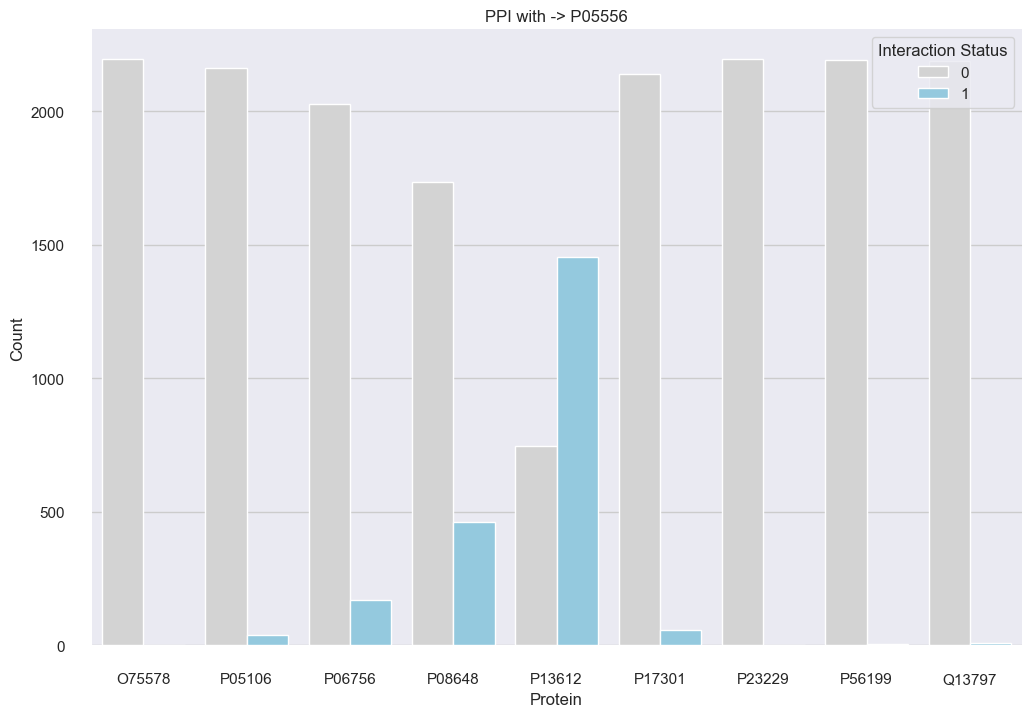

In [267]:
visualize_dist(temp_df_2, unique_proteins[1])

In the plot above, we observe that certain proteins, such as `O75578` and `P23229`, have minimal occurrences in the PPI with `P05106`. In contrast, proteins like `P13612` exhibit frequent appearances in the PPI with '`P05106`.

###### Explore the Second Data Frame ######

In [250]:
PRINT(f'The size of the data frame is -> {len(second_df)}')
print(f'Number of time O75578 appears -> {len(second_df[second_df["UniProt2"] == "O75578"])}')
print(f'Number of time P23229 appears -> {len(second_df[second_df["UniProt2"] == "P23229"])}')
print(f'Number of time P56199 appears -> {len(second_df[second_df["UniProt2"] == "P56199"])}')
print(f'Number of time Q13797 appears -> {len(second_df[second_df["UniProt2"] == "Q13797"])}')
print(f'Number of time P17301 appears -> {len(second_df[second_df["UniProt2"] == "P17301"])}')
print(f'Number of time P05106 appears -> {len(second_df[second_df["UniProt2"] == "P05106"])}')
print(f'Number of time P06756 appears -> {len(second_df[second_df["UniProt2"] == "P06756"])}')
print(f'Number of time P08648 appears -> {len(second_df[second_df["UniProt2"] == "P08648"])}')
print(f'Number of time P13612 appears -> {len(second_df[second_df["UniProt2"] == "P13612"])}')

PRINT('Done.')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The size of the data frame is -> 2197
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Number of time O75578 appears -> 1
Number of time P23229 appears -> 1
Number of time P56199 appears -> 6
Number of time Q13797 appears -> 10
Number of time P17301 appears -> 57
Number of time P05106 appears -> 37
Number of time P06756 appears -> 170
Number of time P08648 appears -> 463
Number of time P13612 appears -> 1452
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Done.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


#### Third Data Frame ####

In [263]:
third_df = protein_dataframes[unique_proteins[2]]

third_df.head(2)

,SMILES,UniProt1,UniProt2
0,CC(C)Oc1ccc(C(CC(=O)O)NC(=O)CCC(=O)Nc2ccc3c(c2...,P05106,P26006
1,COc1ccc(C(CC(=O)O)NC(=O)c2cccc(C(=O)Nc3ccc4c(c...,P05106,P26006


##### Visualize Distribution #####

In [264]:
third_df_encoded = one_hot_encoding(third_df)

In [265]:
third_df_encoded.columns

Index(['SMILES', 'P05106', 'P05556', 'P06756', 'P08514', 'P17301', 'P26006'], dtype='object')

In [261]:
third_df_encoded.head(3)

,SMILES,P05106,P05556,P06756,P08514,P17301,P26006
0,CC(C)Oc1ccc(C(CC(=O)O)NC(=O)CCC(=O)Nc2ccc3c(c2...,1,0,0,0,0,1
1,COc1ccc(C(CC(=O)O)NC(=O)c2cccc(C(=O)Nc3ccc4c(c...,1,0,0,0,0,1
2,COc1ccc(C(CC(=O)O)NC(=O)CCC(=O)Nc2ccc3c(c2)CNC...,1,0,0,0,0,1


In [262]:
filtered_columns = filter_proteins_list(third_df_encoded, columns_to_remove = ['SMILES', 'P05106'])
PRINT(f'Filtered columns -> {filtered_columns}')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Filtered columns -> ['P05556', 'P06756', 'P08514', 'P17301', 'P26006']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [269]:
temp_df_3 = third_df_encoded[filtered_columns]

temp_df_3.head(5)

,P05556,P06756,P08514,P17301,P26006
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


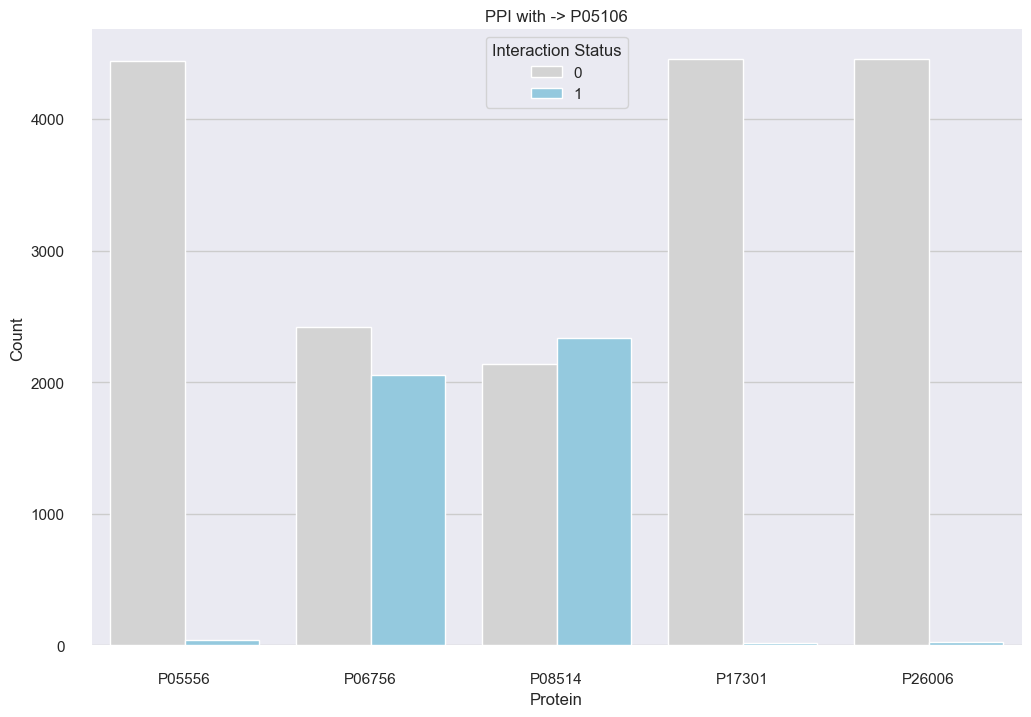

In [270]:
visualize_dist(temp_df_3, unique_proteins[2])

###### Explore the Third Data Frame ######

In [272]:
PRINT(f'The size of the data frame is -> {len(third_df)}')
print(f'Number of time P17301 appears -> {len(third_df[third_df["UniProt2"] == "P17301"])}')
print(f'Number of time P05556 appears -> {len(third_df[third_df["UniProt2"] == "P05556"])}')
print(f'Number of time P26006 appears -> {len(third_df[third_df["UniProt2"] == "P26006"])}')
print(f'Number of time P06756 appears -> {len(third_df[third_df["UniProt2"] == "P06756"])}')
print(f'Number of time P08514 appears -> {len(third_df[third_df["UniProt2"] == "P08514"])}')

PRINT('Done.')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The size of the data frame is -> 4478
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Number of time P17301 appears -> 20
Number of time P05556 appears -> 37
Number of time P26006 appears -> 25
Number of time P06756 appears -> 2058
Number of time P08514 appears -> 2338
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Done.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


#### Fourth Data Frame ####

In [282]:
fourth_df = protein_dataframes[unique_proteins[3]]

fourth_df.head(2)

,SMILES,UniProt1,UniProt2
0,COC(=O)CN1C(=O)S/C(=C\c2ccc(-c3ccc(C(=O)O)cc3)...,P05107,P11215
1,Cc1ccc(/C=C2\SC(=O)N(C)C2=O)o1,P05107,P11215


##### Visualize Distribution #####

In [283]:
fourth_df_encoded = one_hot_encoding(fourth_df)

In [284]:
fourth_df_encoded.columns

Index(['SMILES', 'P05107', 'P11215', 'P20701'], dtype='object')

In [285]:
fourth_df_encoded.head(3)

,SMILES,P05107,P11215,P20701
0,COC(=O)CN1C(=O)S/C(=C\c2ccc(-c3ccc(C(=O)O)cc3)...,1,1,0
1,Cc1ccc(/C=C2\SC(=O)N(C)C2=O)o1,1,1,0
2,CCN1/C(=C/C=C/c2sc3ccccc3[n+]2CC)Sc2ccccc21.[I-],1,1,0


In [286]:
filtered_columns = filter_proteins_list(fourth_df_encoded, columns_to_remove=['SMILES', 'P05107'])
PRINT(f'Filtered columns -> {filtered_columns}')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Filtered columns -> ['P11215', 'P20701']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [290]:
temp_df_4 = fourth_df_encoded[filtered_columns]

temp_df_4.head(2)

,P11215,P20701
0,1,0
1,1,0


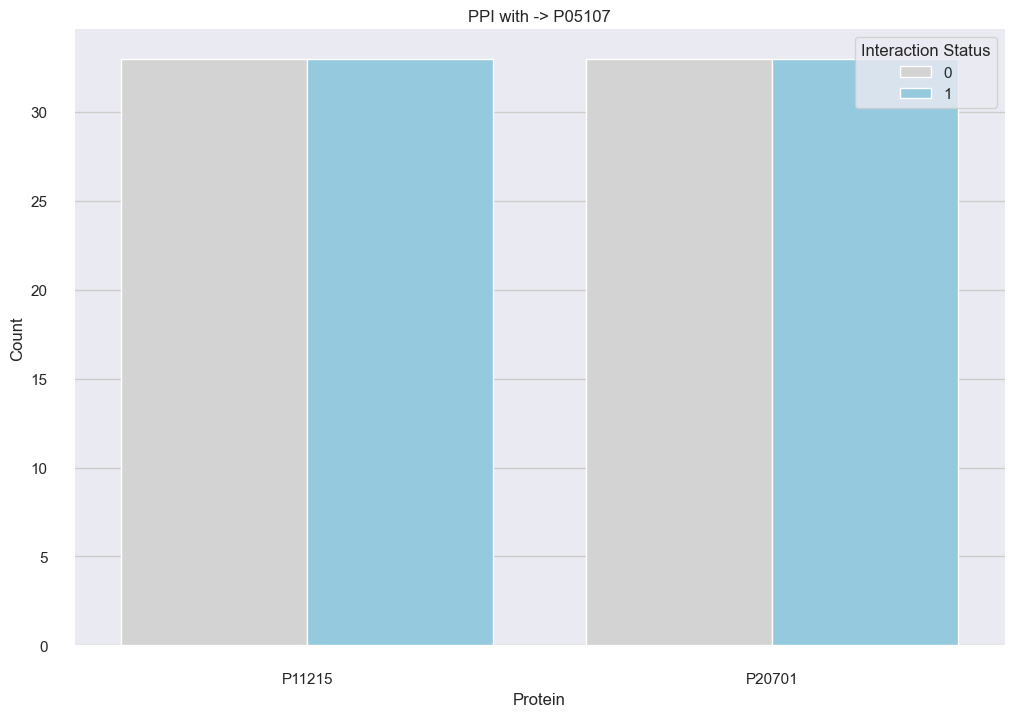

In [291]:
visualize_dist(temp_df_4, unique_proteins[3])

The data above is quite interesting, indicating that both proteins appear the same number of times in the PPI with `P05107`.

##### Explore the Fourth Data Frame ######

In [294]:
PRINT(f'The size of the data frame is -> {len(fourth_df)}')
print(f'Number of time P11215 appears -> {len(fourth_df[fourth_df["UniProt2"] == "P11215"])}')
print(f'Number of time P20701 appears -> {len(fourth_df[fourth_df["UniProt2"] == "P20701"])}')

PRINT('Done.')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The size of the data frame is -> 66
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Number of time P11215 appears -> 33
Number of time P20701 appears -> 33
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Done.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


#### Fifth Data Frame ####

In [296]:
fifth_df = protein_dataframes[unique_proteins[4]]

fifth_df.head(2)

,SMILES,UniProt1,UniProt2
0,O=C(N[C@@H](Cc1cccc(OCCCCNc2ccccn2)c1)C(=O)O)c...,P08648,P05556
1,CC(C)[C@@H]1NC(=O)[C@@H](Cc2c[nH]c3c(-c4ccc(C(...,P08648,P05556


##### Visualize Distribution #####

In [297]:
fifth_df_encoded = one_hot_encoding(fifth_df)

In [298]:
fifth_df_encoded.columns

Index(['SMILES', 'P08648', 'P05556', 'P06756'], dtype='object')

In [302]:
fifth_df_encoded.head(3)

,SMILES,P08648,P05556,P06756
0,O=C(N[C@@H](Cc1cccc(OCCCCNc2ccccn2)c1)C(=O)O)c...,1,1,0
1,CC(C)[C@@H]1NC(=O)[C@@H](Cc2c[nH]c3c(-c4ccc(C(...,1,1,0
2,CC(C)[C@@H]1NC(=O)[C@@H](Cc2c[nH]c3c(-c4ccc5cc...,1,1,0


In [303]:
filtered_columns = filter_proteins_list(fifth_df_encoded, columns_to_remove=['SMILES', 'P08648'])
PRINT(f'Filtered columns -> {filtered_columns}')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Filtered columns -> ['P05556', 'P06756']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [305]:
temp_df_5 = fifth_df_encoded[filtered_columns]

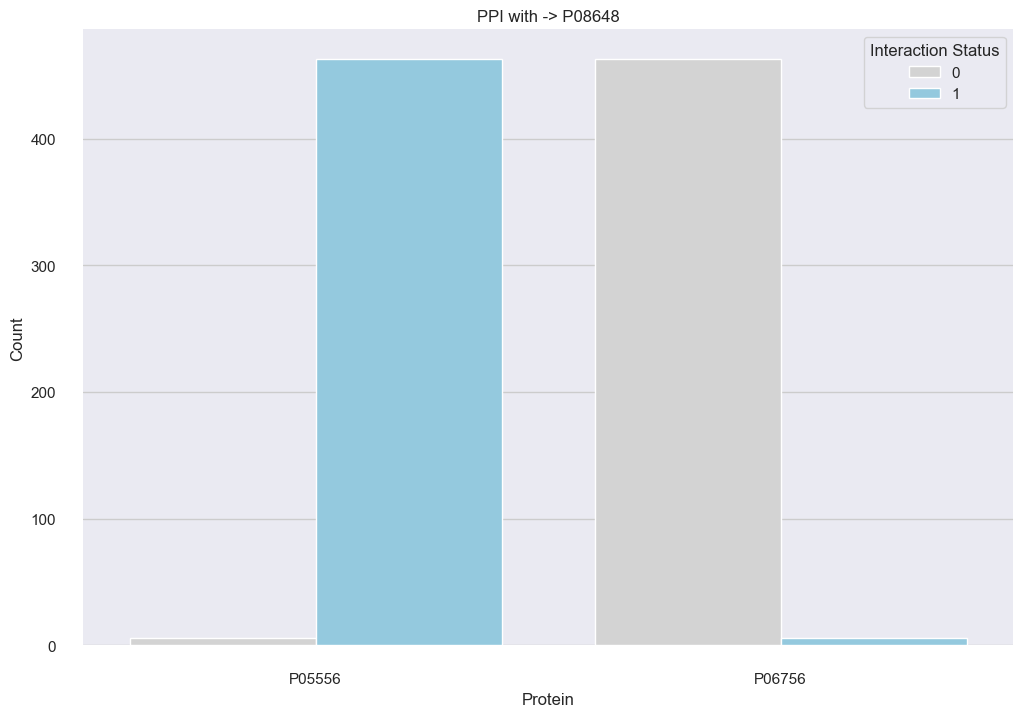

In [307]:
visualize_dist(temp_df_5, unique_proteins[4])

Here, we observe a particularly interesting distribution of the data. The majority of the fifth dataset represents PPI between the target protein with `UniProt = P08648` and `P05556`. Conversely, there are very few interactions involving `P06756`.

##### Explore the Fifth Data Frame ######

In [309]:
PRINT(f'The size of the data frame is -> {len(fifth_df)}')
print(f'Number of time P05556 appears -> {len(fifth_df[fifth_df["UniProt2"] == "P05556"])}')
print(f'Number of time P0756 appears -> {len(fifth_df[fifth_df["UniProt2"] == "P06756"])}')

PRINT('Done.')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The size of the data frame is -> 469
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Number of time P05556 appears -> 463
Number of time P0756 appears -> 6
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Done.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


#### Sixth Data Frame ####

In [310]:
sixth_df = protein_dataframes[unique_proteins[5]]

sixth_df.head(2)

,SMILES,UniProt1,UniProt2
0,Cc1cccc(Cl)c1C(=O)N[C@@H](Cc1ccc(NC(=O)c2c(Cl)...,P17301,P05556
1,COc1ccc(S(=O)(=O)N2Cc3[nH]c4ccccc4c3CC2C(N)=O)cc1,P17301,P05556


##### Visualize Distribution #####

In [311]:
sixth_df_encoded = one_hot_encoding(sixth_df)

In [312]:
sixth_df_encoded.columns

Index(['SMILES', 'P17301', 'P05106', 'P05556'], dtype='object')

In [313]:
sixth_df_encoded.head(3)

,SMILES,P17301,P05106,P05556
0,Cc1cccc(Cl)c1C(=O)N[C@@H](Cc1ccc(NC(=O)c2c(Cl)...,1,0,1
1,COc1ccc(S(=O)(=O)N2Cc3[nH]c4ccccc4c3CC2C(N)=O)cc1,1,0,1
2,O=C(NCc1ccccc1)NC[C@H](NC(=O)[C@@H]1CCCN1S(=O)...,1,0,1


In [314]:
filtered_columns = filter_proteins_list(sixth_df_encoded, columns_to_remove=['SMILES', 'P17301'])
PRINT(f'Filtered columns -> {filtered_columns}')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Filtered columns -> ['P05106', 'P05556']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [315]:
temp_df_6 = sixth_df_encoded[filtered_columns]

temp_df_6.head(2)

,P05106,P05556
0,0,1
1,0,1


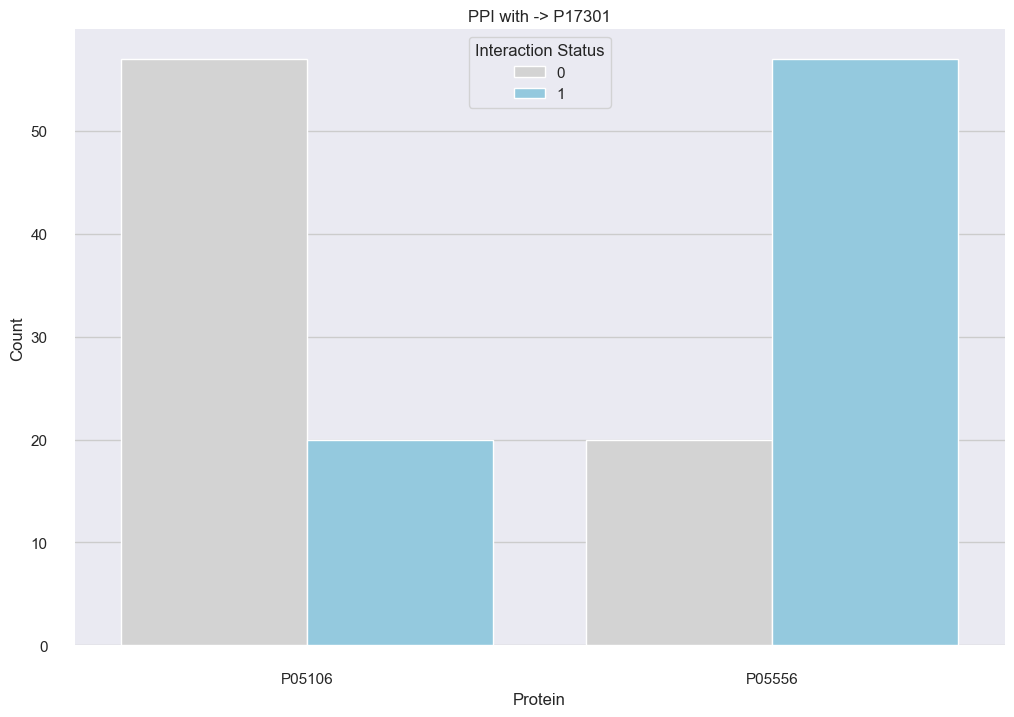

In [316]:
visualize_dist(temp_df_6, unique_proteins[5])

##### Explore the Sixth Dath Frame #####

In [317]:
PRINT(f'The size of the data frame is -> {len(sixth_df)}')
print(f'Number of time P05106 appears -> {len(sixth_df[sixth_df["UniProt2"] == "P05106"])}')
print(f'Number of time P05556 appears -> {len(sixth_df[sixth_df["UniProt2"] == "P05556"])}')

PRINT('Done.')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The size of the data frame is -> 77
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Number of time P05106 appears -> 20
Number of time P05556 appears -> 57
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Done.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### Save the Encoded csv Files ###

In [355]:
encoded_dir_path = 'one hot encoded csv files for training'

first_df_encoded.to_csv(os.path.join('one hot encoded csv files for training/first_df_encoded.csv'), index=False)
second_df_encoded.to_csv(os.path.join('one hot encoded csv files for training/second_df_encoded.csv'), index=False)
third_df_encoded.to_csv(os.path.join('one hot encoded csv files for training/third_df_encoded.csv'), index=False)
fourth_df_encoded.to_csv(os.path.join('one hot encoded csv files for training/fourth_df_encoded.csv'), index=False)
fifth_df_encoded.to_csv(os.path.join('one hot encoded csv files for training/fifth_df_encoded.csv'), index=False)
sixth_df_encoded.to_csv(os.path.join('one hot encoded csv files for training/sixth_df_encoded.csv'), index=False)

PRINT('Done.')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Done.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


## Build and Train Predictive Models for PPI ##

### Import Libraries ###

In [7]:
import pickle # In order to load the saved data frames dictionary
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops

In [29]:
import deepchem as dc
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from deepchem.feat import RDKitDescriptors
from deepchem.models import GraphConvModel
from deepchem.hyper import GridHyperparamOpt
from deepchem.splits.splitters import RandomGroupSplitter
from deepchem.hyper import HyperparamOpt
from deepchem.trans import undo_transforms
from deepchem.trans.transformers import BalancingTransformer

### Construct the Datasets ###

First we need to load our saved data frames dictionary

In [9]:
dict_path = 'obj/data_frames_dictionary.pkl'

In [10]:
try:
    with open('obj/data_frames_dictionary.pkl', 'rb') as file:
        df_dict = pickle.load(file)
        PRINT(f'Done.')
except Exception as e:
    PRINT(f'Error in loading the saved data frames dicitonary from obj dir')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Done.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [11]:
prot_ls = list(df_dict.keys())

PRINT(f'Unique proteins -> {prot_ls}')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Unique proteins -> ['P13612', 'P05556', 'P05106', 'P05107', 'P08648', 'P17301']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### Models for P13612 Protein ###

In [12]:
csv_dir_path = 'one hot encoded csv files for training' 

In [13]:
first_ds = pd.read_csv(os.path.join(csv_dir_path, 'first_df_encoded.csv'))

In [14]:
first_ds.head(3)

,SMILES,P13612,P05556,P26010
0,COc1ccccc1-c1ccc(C[C@H](NC(=O)c2ccccc2Cl)C(=O)...,1,0,1
1,Cc1ccccc1NC(=O)Nc1ccc(CC(=O)N2C[C@@H](F)C[C@H]...,1,0,1
2,CN(C)Cc1ccccc1-c1ccc(C[C@H](NC(=O)c2ccccc2Cl)C...,1,0,1


In [15]:
first_ds.drop('P13612', axis=1, inplace=True)

first_ds.head(2)

,SMILES,P05556,P26010
0,COc1ccccc1-c1ccc(C[C@H](NC(=O)c2ccccc2Cl)C(=O)...,0,1
1,Cc1ccccc1NC(=O)Nc1ccc(CC(=O)N2C[C@@H](F)C[C@H]...,0,1


#### Graph Conv Model ####

In [285]:
curr_df.head(2)

,SMILES,UniProtTargetLabels,NumericUniProtTargetLabels
0,COc1ccccc1-c1ccc(C[C@H](NC(=O)c2ccccc2Cl)C(=O)...,P26010,1
1,Cc1ccccc1NC(=O)Nc1ccc(CC(=O)N2C[C@@H](F)C[C@H]...,P26010,1


In [286]:
df_conv = curr_df.drop('UniProtTargetLabels', axis=1)

df_conv.head(2)

,SMILES,NumericUniProtTargetLabels
0,COc1ccccc1-c1ccc(C[C@H](NC(=O)c2ccccc2Cl)C(=O)...,1
1,Cc1ccccc1NC(=O)Nc1ccc(CC(=O)N2C[C@@H](F)C[C@H]...,1


In [293]:
df_conv.to_csv('P13612_conv_data.csv', index=False)

##### Hyperparameter Tuning for Graph Conv Model #####

In [288]:
def gc_model_builder(**model_params,):
    """

    """
    learning_rate = model_params['learning_rate']
    graph_conv_layers = model_params['graph_conv_layers']
    dense_layer_size = model_params['dense_layer_size']
    dropout = model_params['dropout']
    batch_size = model_params['batch_size']
    batch_normalize = model_params['batch_normalize']
    n_classes=model_params['n_classes']
    
    
    return GraphConvModel(n_tasks=1,
                          batch_size=batch_size,
                          graph_conv_layers=graph_conv_layers,
                          dense_layer_size=dense_layer_size,
                          dropout=dropout,
                          mode='classification',
                          model_dir='models',
                          batch_normalize=batch_normalize,
                          n_classes=n_classes,
                          learning_rate=learning_rate
                          )

In [291]:
def execute_hyperparameter_tuning_for_graph_conv(csv_data, df, params):
    """

    """
    tasks = ['NumericUniProtTargetLabels']
    featurizer = dc.feat.ConvMolFeaturizer()
    loader = dc.data.CSVLoader(tasks=tasks,
                               smiles_field='SMILES',
                               featurizer=featurizer)
    
    splitter = dc.splits.RandomSplitter()
    mean_roc_auc_metric = dc.metrics.Metric(metric=dc.metrics.roc_auc_score, task_averager=np.mean, mode='classification', n_tasks=1)

    dataset = loader.featurize(csv_data)
    
    res = splitter.train_valid_test_split(dataset)
    train_dataset, valid_dataset, test_dataset = res
    
    # Create a hyperparameter optimization object
    opt = GridHyperparamOpt(gc_model_builder)
    best_model, best_hyperparams, all_results = opt.hyperparam_search(params, train_dataset, valid_dataset, mean_roc_auc_metric)

    return [best_hyperparams, all_results]

In [ ]:
# Define the hyperparameter grid
params = {
    'learning_rate': [1e-3, 5e-4, 1e-4],
    'graph_conv_layers': [[64, 64], [128, 128]],
    'dense_layer_size': [64, 128, 256],
    'dropout': [0.2, 0.4],
    'batch_size': [32, 64],
    'batch_normalize': [True, False],
    'n_classes': [2]
}

# Execute hyperparameter tuning for graph conv model for the first dataset
res_ls = execute_hyperparameter_tuning_for_graph_conv(csv_data = 'P13612_conv_data.csv', df=df_conv, params=params)

In [62]:
PRINT(f"The results after preforming Grid Hyperparameter Optimization technique are:")
PRINT(f"Best hyperparameters (learning_rate, dropout, batch_size) -> {res_ls[0]}")
PRINT(f"All results :\n\n{res_ls[1]}")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The results after preforming Grid Hyperparameter Optimization technique are:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Best hyperparameters (learning_rate, dropout, batch_size) -> (0.001, 0.2, 32)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
All results :

{'_batch_size_32_dropout_0.200000_learning_rate_0.001000': 0.8011347517730496, '_batch_size_64_dropout_0.200000_learning_rate_0.001000': 0.7849645390070923, '_batch_size_32_dropout_0.500000_learning_rate_0.001000': 0.7651063829787234, '_batch_size_64_dropout_0.500000_learning_rate_0.001000': 0.6212765957446809, '_batch_size_32_dropout_0.200000_learning_rate_0.000100': 0.8004964539007092, '_batch_size_64_dropout_0.200000_l

##### Build and Train Graph Conv Model #####

In [601]:
def generate_graph_conv_model(n_tasks, learning_rate):
    batch_size = 64
    model = GraphConvModel(n_tasks=n_tasks, 
                           batch_size=batch_size,
                           mode = 'classification',
                           model_dir = 'models',
                           n_classes=2,
                          learning_rate=learning_rate)
    return model           

In [602]:
tasks = list(first_ds.columns[1:])
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks,
                           smiles_field='SMILES',
                           featurizer=featurizer)
dataset = loader.featurize('first_ds_for_train.csv')

smiles_field is deprecated and will be removed in a future version of DeepChem.Use feature_field instead.
C:\Users\gavvi\anaconda3\Lib\site-packages\deepchem\data\data_loader.py:160: FutureWarning: featurize() is deprecated and has been renamed to create_dataset().featurize() will be removed in DeepChem 3.0
  warnings.warn(


In [603]:
dataset

<DiskDataset X.shape: (1974,), y.shape: (1974, 2), w.shape: (1974, 2), task_names: ['P05556' 'P26010']>

In [604]:
splitter = dc.splits.RandomSplitter()

In [605]:
metrics = [dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode='classification')]

In [606]:
res = splitter.train_valid_test_split(dataset)
train_dataset, valid_dataset, test_dataset = res

In [616]:
PRINT(f'Shapes (train, valid, test) -> : {(train_dataset.X.shape, valid_dataset.X.shape, test_dataset.X.shape)}')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Shapes (train, valid, test) -> : ((1579,), (197,), (198,))
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [608]:
training_score_list = []
validation_score_list = []
transformers = []
cv_folds = 10

In [609]:
for i in range(0, cv_folds):
    model = generate_graph_conv_model(2)
    res = splitter.train_valid_test_split(dataset)
    
    train_dataset, valid_dataset, test_dataset = res
    
    model.fit(train_dataset, nb_epoch=10)
    
    # Train step
    train_scores = model.evaluate(train_dataset, metrics,
                                  transformers)

    training_score_list.append(
        train_scores['mean-roc_auc_score'])
    
    # Validation step
    validation_scores = model.evaluate(valid_dataset, metrics,
                                       transformers)
    validation_score_list.append(
        validation_scores['mean-roc_auc_score'])

In [610]:
PRINT(training_score_list)
PRINT(validation_score_list)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[0.8257149617315448, 0.8209986441320591, 0.8235109139546, 0.8108322362000009, 0.8055811547865338, 0.8065282379678009, 0.7863595870071726, 0.7896867048346057, 0.7762394729693018, 0.8170065011820331]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[0.7806204673650282, 0.7493177871495906, 0.7576642335766424, 0.8066747246843944, 0.8025372311086596, 0.7234793187347932, 0.7928519768563163, 0.7347784885098319, 0.7904002026342452, 0.7568384681831269]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


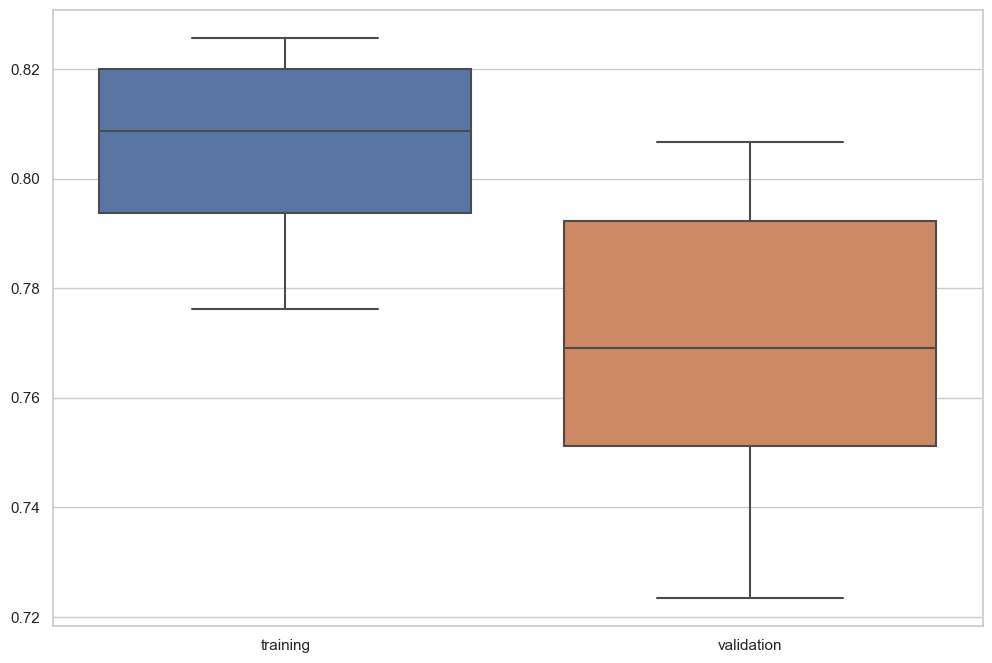

In [611]:
# Create a DataFrame with the data
data = {
    'Group': ["training"] * cv_folds + ["validation"] * cv_folds,
    'Score': training_score_list + validation_score_list
}

# Create a boxplot
sns.boxplot(x="Group", y="Score", data=data)

# Show the plot
plt.show()

In [550]:
valid_dataset.y.shape

(197, 2)

In [555]:
y_transposed = valid_dataset.y.transpose()

In [558]:
y_transposed.shape

(2, 197)

In [559]:
pred_df[tasks[0]] = [int(x) for x in y_transposed[0]]
pred_df[tasks[1]] = [int(x) for x in y_transposed[1]]
pred_df["SMILES"] = valid_dataset.ids

In [564]:
pred_df.head(10)

,0_P05556,1_P05556,0_P26010,1_P26010,P05556,P26010,SMILES
0,0.237262,0.762738,0.533614,0.466386,1,0,COc1ccccc1-c1ccc(C[C@H](NC(=O)C2CCCS2(=O)=O)C(...
1,0.326104,0.673896,0.680256,0.319744,0,1,CC(C)C[C@H]1NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@@H...
2,0.092497,0.907503,0.898937,0.101063,1,0,CC(=O)N1CSC[C@@H]1C(=O)N[C@@H](Cc1ccc(OCc2c(Cl...
3,0.015062,0.984938,0.976549,0.023451,1,0,NC(=O)C1(NC(=O)[C@@H](CCCC(=O)O)NC(=O)[C@@H](C...
4,0.124486,0.875514,0.857985,0.142015,1,0,Cc1ccnc(C)c1C(=O)N[C@@H](Cc1ccc(NC(=O)c2c(Cl)c...
5,0.136475,0.863525,0.635067,0.364933,1,0,O=C(Nc1ccc(C[C@H](NC(=O)C2(c3ccccc3)CCCC2)C(=O...
6,0.166778,0.833222,0.761115,0.238885,1,0,C[C@@]1(C(=O)N[C@@H](Cc2ccc(-c3cccnc3)cc2)C(=O...
7,0.018955,0.981045,0.967087,0.032913,1,0,NC(=O)C1(NC(=O)[C@@H](CCCC(=O)O)NC(=O)[C@@H](C...
8,0.008757,0.991243,0.985325,0.014675,1,0,Cc1ccc(C(=O)Nc2ccc(C[C@H](NC(=O)C3CCC(=O)N3Cc3...
9,0.007507,0.992493,0.987144,0.012856,1,0,Cc1ccccc1NC(=O)Nc1ccc(CC(=O)N[C@@H](CC(C)C)C(=...


#### Random Forest & XGBoost Models using RKDKit for Generating Features ####

In [334]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

##### Generate Data Frame with Numeric Labels #####

First, load the csv file into data frame.

In [153]:
csv_file_name = 'P13612.csv'
csv_dir = 'unique UniProt csv files'

one_hot_encoded_csv = 'first_df_encoded.csv'
csv_dir_ohe = 'one hot encoded csv files for training'

curr_df = pd.read_csv(os.path.join(csv_dir, csv_file_name))
ohe_df = pd.read_csv(os.path.join(csv_dir_ohe, one_hot_encoded_csv))

In [154]:
curr_df.head(2)

,SMILES,UniProt1,UniProt2
0,COc1ccccc1-c1ccc(C[C@H](NC(=O)c2ccccc2Cl)C(=O)...,P13612,P26010
1,Cc1ccccc1NC(=O)Nc1ccc(CC(=O)N2C[C@@H](F)C[C@H]...,P13612,P26010


In [155]:
curr_df.drop('UniProt1', axis=1, inplace=True)
curr_df = curr_df.rename(columns={'UniProt2':'UniProtTargetLabels'})


curr_df.head(2)

,SMILES,UniProtTargetLabels
0,COc1ccccc1-c1ccc(C[C@H](NC(=O)c2ccccc2Cl)C(=O)...,P26010
1,Cc1ccccc1NC(=O)Nc1ccc(CC(=O)N2C[C@@H](F)C[C@H]...,P26010


In [156]:
ohe_df.head(2)

,SMILES,P13612,P05556,P26010
0,COc1ccccc1-c1ccc(C[C@H](NC(=O)c2ccccc2Cl)C(=O)...,1,0,1
1,Cc1ccccc1NC(=O)Nc1ccc(CC(=O)N2C[C@@H](F)C[C@H]...,1,0,1


In [157]:
labels = ohe_df.columns[2:].tolist()

PRINT(f'First model labels -> {labels}')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
First model labels -> ['P05556', 'P26010']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [158]:
column_name_to_index = {label: i for i, label in enumerate(labels)}

# Map the 'labels' column in df to column indices
curr_df['NumericUniProtTargetLabels'] = curr_df['UniProtTargetLabels'].map(column_name_to_index)

In [159]:
curr_df.head(5)

,SMILES,UniProtTargetLabels,NumericUniProtTargetLabels
0,COc1ccccc1-c1ccc(C[C@H](NC(=O)c2ccccc2Cl)C(=O)...,P26010,1
1,Cc1ccccc1NC(=O)Nc1ccc(CC(=O)N2C[C@@H](F)C[C@H]...,P26010,1
2,CN(C)Cc1ccccc1-c1ccc(C[C@H](NC(=O)c2ccccc2Cl)C...,P26010,1
3,Cc1cccc(Cl)c1C(=O)N[C@@H](Cc1ccc(NC(=O)c2c(Cl)...,P26010,1
4,COc1cnn(C)c(=O)c1-c1ccc(C[C@H](NC(=O)c2c(C)noc...,P26010,1


In [160]:
df_for_model = curr_df.drop('UniProtTargetLabels', axis=1)

df_for_model.head(2)

,SMILES,NumericUniProtTargetLabels
0,COc1ccccc1-c1ccc(C[C@H](NC(=O)c2ccccc2Cl)C(=O)...,1
1,Cc1ccccc1NC(=O)Nc1ccc(CC(=O)N2C[C@@H](F)C[C@H]...,1


##### Generate Fetures by Molecule SMILES Using RDKitDescriptors Method #####

In [161]:
from rdkit import Chem
from rdkit.Chem import Descriptors

In [162]:
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        descriptors = [
            Descriptors.MolWt(mol),
            Descriptors.NumValenceElectrons(mol),
            Descriptors.TPSA(mol),
            Descriptors.MolLogP(mol),
            Descriptors.NumHeteroatoms(mol),
            Descriptors.NumRotatableBonds(mol),
            Descriptors.HeavyAtomCount(mol),
            Descriptors.FractionCSP3(mol)
        ]
        return descriptors
    else:
        return [None] * 8  # Return None for each descriptor if SMILES cannot be parsed

In [163]:
def GenerateFeaturesByMoleculeSMILES(df) -> pd.DataFrame:
    """


    """
    # Apply the `calculate_descriptors` method in order to generate 8 new features for df
    df['MolecularDescriptors'] = df['SMILES'].apply(calculate_descriptors)

    # Transfer the array at each row under the 'MolecularDescriptors' column into column with their corresponding names & drop the colunn
    df[['MolWt', 'NumValenceElectrons', 'TPSA', 'MolLogP', 'NumHeteroatoms', 'NumRotatableBonds', 'HeavyAtomCount', 'FractionCSP3']] = pd.DataFrame(df['MolecularDescriptors'].tolist(), index=df.index)
    df.drop(columns=['MolecularDescriptors'], axis=1, inplace=True)

    # Reorder the columns names so that the label column will be the last column in df
    df = df[['SMILES', 'MolWt', 'NumValenceElectrons', 'TPSA', 'MolLogP', 'NumHeteroatoms', 'NumRotatableBonds', 'HeavyAtomCount', 'FractionCSP3', 'NumericUniProtTargetLabels']]

    return df

In [164]:
df_1 = GenerateFeaturesByMoleculeSMILES(df_for_model)

In [165]:
df_1.head(3)

,SMILES,MolWt,NumValenceElectrons,TPSA,MolLogP,NumHeteroatoms,NumRotatableBonds,HeavyAtomCount,FractionCSP3,NumericUniProtTargetLabels
0,COc1ccccc1-c1ccc(C[C@H](NC(=O)c2ccccc2Cl)C(=O)...,409.869,148,75.63,4.44130,6,7,29,0.130435,1
1,Cc1ccccc1NC(=O)Nc1ccc(CC(=O)N2C[C@@H](F)C[C@H]...,539.991,198,107.97,5.55112,10,8,38,0.250000,1
2,CN(C)Cc1ccccc1-c1ccc(C[C@H](NC(=O)c2ccccc2Cl)C...,436.939,160,69.64,4.49430,6,8,31,0.200000,1


In [166]:
PRINT(f'Set of data frame columns after generating new features by molecules SMILES are:\n\n{list(df_1.columns)}\n\nNumer of column: {len(list(df_1.columns))}')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Set of data frame columns after generating new features by molecules SMILES are:

['SMILES', 'MolWt', 'NumValenceElectrons', 'TPSA', 'MolLogP', 'NumHeteroatoms', 'NumRotatableBonds', 'HeavyAtomCount', 'FractionCSP3', 'NumericUniProtTargetLabels']

Numer of column: 10
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


##### Building Random Forest Model #####

In [311]:
def GenerateRandomForestModel(df, not_balanced):
    """


    """
    
    # Drop non-numeric column 'SMILES' and the labels column
    X = df.drop(['SMILES', 'NumericUniProtTargetLabels'], axis=1)
    y = df['NumericUniProtTargetLabels']
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create a Random Forest classifier
    if not_balanced:
        rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
    else:
        rf_model = RandomForestClassifier(random_state=42)
    
    # Use StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define a parameter distribution
    param_grid = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 8]
    }
    
    # Use a custom scoring function (weighted F1) for GridSearchCV
    scoring = make_scorer(f1_score, average='weighted')
    
    # Perform GridSearchCV with StratifiedKFold
    grid_search = GridSearchCV(rf_model, param_grid, cv=stratified_kfold, scoring=scoring)
    grid_search.fit(X_train, y_train)
    
    # Get the best hyperparameters
    best_params = grid_search.best_params_
    
    # Create a Random Forest classifier with the best hyperparameters
    if not_balanced:
        best_rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, **best_params)
    else:
        best_rf_model = RandomForestClassifier(random_state=42, **best_params)
        
    # Train the model on the entire training set
    best_rf_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_test_pred = best_rf_model.predict(X_test)
    
    # Evaluate the model on the test set
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred, average='weighted')
    recall_test = recall_score(y_test, y_test_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)
    
    # Return the trained model and evaluation metrics
    return best_rf_model, {
        'accuracy': accuracy_test,
        'precision': precision_test,
        'recall': recall_test,
        'f1_score': f1_test,
        'confusion_matrix': conf_matrix_test.tolist()
    }


In [314]:
df_1.columns

Index(['SMILES', 'MolWt', 'NumValenceElectrons', 'TPSA', 'MolLogP',
       'NumHeteroatoms', 'NumRotatableBonds', 'HeavyAtomCount', 'FractionCSP3',
       'NumericUniProtTargetLabels'],
      dtype='object')

In [315]:
model_dict_rf = GenerateRandomForestModel(df=df_1, not_balanced=True)

In [332]:
PRINT('Model Dictionary:')
print_dict_meaningful(model_dict[1])
PRINT('Done.')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Model Dictionary:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
accuracy: 0.6556962025316456
precision: 0.7106873898413717
recall: 0.6556962025316456
f1_score: 0.6725860909718059
confusion_matrix: [[195, 94], [42, 64]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Done.
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


##### Building XGBoost Model ##### 

In [341]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def GenerateXGBoostModel(df):
    
    # Drop non-numeric column 'SMILES' and the labels column
    X = df.drop(['SMILES', 'NumericUniProtTargetLabels'], axis=1)
    y = df['NumericUniProtTargetLabels']
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print('test')
    # Create an XGBoost classifier
    xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(set(y_train)), random_state=42)
    
    # Use StratifiedKFold for cross-validation
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define an extended parameter distribution
    param_grid = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2, 0.3],
        'min_child_weight': [1, 3, 5, 7],
        'reg_alpha': [0, 0.1, 0.5, 1],
        'reg_lambda': [0, 0.1, 0.5, 1]
    }
    
    # Use a custom scoring function (weighted F1) for GridSearchCV
    scoring = make_scorer(f1_score, average='weighted')
    
    # Perform GridSearchCV with StratifiedKFold
    grid_search = GridSearchCV(xgb_model, param_grid, cv=stratified_kfold, scoring=scoring)
    grid_search.fit(X_train, y_train)
    
    # Get the best hyperparameters
    best_params = grid_search.best_params_
    
    # Create an XGBoost classifier with the best hyperparameters
    best_xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(set(y_train)), random_state=42, **best_params)
        
    # Train the model on the entire training set
    best_xgb_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_test_pred = best_xgb_model.predict(X_test)
    
    # Evaluate the model on the test set
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred, average='weighted')
    recall_test = recall_score(y_test, y_test_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)
    
    # Print the classification report
    print('Classification Report:')
    print(classification_report(y_test, y_test_pred))
       
    # Return the trained model and evaluation metrics
    return best_xgb_model, {
        'accuracy': accuracy_test,
        'precision': precision_test,
        'recall': recall_test,
        'f1_score': f1_test,
        'confusion_matrix': conf_matrix_test.tolist()
    }


In [342]:
model_dict_xgb = GenerateXGBoostModel(df=df_1)

test


KeyboardInterrupt: 

# TODO : The next code just in case i'll use SMILES augmentation, delete it at the end #

In [278]:
test_df = curr_df.drop('UniProtTargetLabels', axis=1)

test_df.head(3)

,SMILES,NumericUniProtTargetLabels
0,COc1ccccc1-c1ccc(C[C@H](NC(=O)c2ccccc2Cl)C(=O)...,1
1,Cc1ccccc1NC(=O)Nc1ccc(CC(=O)N2C[C@@H](F)C[C@H]...,1
2,CN(C)Cc1ccccc1-c1ccc(C[C@H](NC(=O)c2ccccc2Cl)C...,1


In [279]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np

In [280]:
def augment_smiles(smiles, num_augmentations):
    augmented_smiles = []
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # Apply RDKit transformations or modifications here for augmentation
        # For example, you can perform random rotations, translations, etc.
        augmented_mol = AllChem.EnumerateStereoisomers(mol)
        for a_mol in augmented_mol:
            augmented_smiles.append(Chem.MolToSmiles(a_mol))
    return augmented_smiles

In [281]:
augmented_data = {'SMILES': [], 'NumericUniProtTargetLabels': []}

class_1_samples = test_df[test_df['NumericUniProtTargetLabels'] == 1]
for _, row in class_1_samples.iterrows():
    original_smiles = row['SMILES']
    augmented_smiles = augment_smiles(original_smiles, num_samples_per_class)
    augmented_data['SMILES'].extend(augmented_smiles)
    augmented_data['NumericUniProtTargetLabels'].extend([1] * len(augmented_smiles))
    
aug_df = pd.DataFrame(augmented_data)

# Shuffle auf_df to randomize the order of samples
aug_df = aug_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [267]:
test_df

,SMILES,NumericUniProtTargetLabels
0,C[C@@]1(C(=O)N[C@@H](Cc2ccc(-c3ncccc3C#N)cc2)C...,1
1,COc1cccc(OC)c1-c1ccc(C[C@H](NC(=O)[C@]2(C)O[C@...,1
2,CCN(CC)c1ncc(N(CC)S(C)(=O)=O)c(N[C@@H](Cc2ccc(...,1
3,CSCC[C@H](N)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@H]1C...,1
4,CCN(CC)c1ncc(N(CC)C(=O)Nc2ccccc2)c(N[C@@H](Cc2...,1
...,...,...
554,Cc1cc(C[C@H](NC(=O)c2c(Cl)cccc2Cl)C(=O)O)ccc1-...,1
555,CSCC[C@H]1NC(=O)[C@H]([C@@H](C)O)NC(=O)[C@@H](...,1
556,COc1cccc(OC)c1-c1ccc(C[C@H](NC(=O)C2(S(=O)(=O)...,1
557,O=C(O)[C@H]1[C@@H]2CC[C@H](C2)[C@@H]1NC(=O)[C@...,1


#### Selecting the Best Model ####